In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
import os

%matplotlib inline


Class: Basophil
Image: 20190526_162951_0.jpg


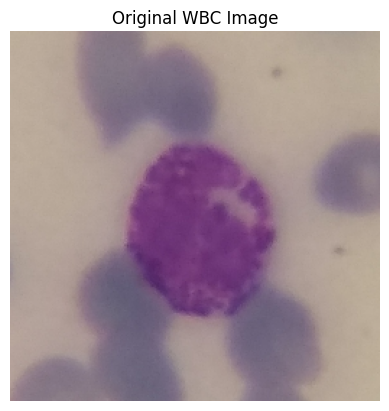

In [ ]:
dataset_root = "archive/Train"

class_name = os.listdir(dataset_root)[0]
class_path = os.path.join(dataset_root, class_name)

image_name = os.listdir(class_path)[0]
image_path = os.path.join(class_path, image_name)

print("Class:", class_name)
print("Image:", image_name)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))

plt.imshow(image)
plt.title("Original WBC Image")
plt.axis("off")
plt.show()


In [3]:
pixels = image.reshape((-1, 3))
pixels = np.float32(pixels)


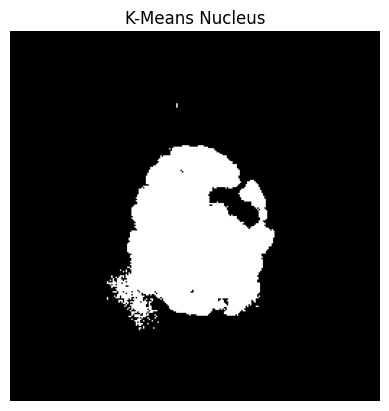

In [ ]:
K = 3

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

_, labels, centers = cv2.kmeans(
    pixels, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS
)

centers = np.uint8(centers)
labels_reshaped = labels.reshape((256, 256))

cluster_intensity_k = [np.mean(center) for center in centers]
nucleus_cluster_k = np.argmin(cluster_intensity_k)

nucleus_mask_kmeans = (labels_reshaped == nucleus_cluster_k)

plt.imshow(nucleus_mask_kmeans, cmap='gray')
plt.title("K-Means Nucleus")
plt.axis("off")
plt.show()


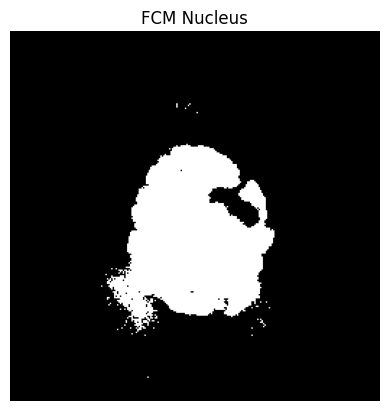

In [ ]:
data = pixels.T

cntr, u, _, _, _, _, fpc = fuzz.cluster.cmeans(
    data, c=3, m=2, error=0.005, maxiter=1000
)

cluster_membership = np.argmax(u, axis=0)
fcm_labels = cluster_membership.reshape((256, 256))

cluster_intensity_f = [np.mean(center) for center in cntr]
nucleus_cluster_f = np.argmin(cluster_intensity_f)

nucleus_mask_fcm = (fcm_labels == nucleus_cluster_f)

plt.imshow(nucleus_mask_fcm, cmap='gray')
plt.title("FCM Nucleus")
plt.axis("off")
plt.show()


In [6]:
mask_k = (nucleus_mask_kmeans.astype(np.uint8)) * 255
mask_f = (nucleus_mask_fcm.astype(np.uint8)) * 255

contours_k, _ = cv2.findContours(mask_k, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_f, _ = cv2.findContours(mask_f, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

perimeter_k = sum(cv2.arcLength(cnt, True) for cnt in contours_k)
perimeter_f = sum(cv2.arcLength(cnt, True) for cnt in contours_f)

print("Boundary Perimeter (K-Means):", perimeter_k)
print("Boundary Perimeter (FCM):", perimeter_f)
print("Fuzzy Partition Coefficient:", fpc)


Boundary Perimeter (K-Means): 809.0336120128632
Boundary Perimeter (FCM): 759.4356336593628
Fuzzy Partition Coefficient: 0.8560548399876524


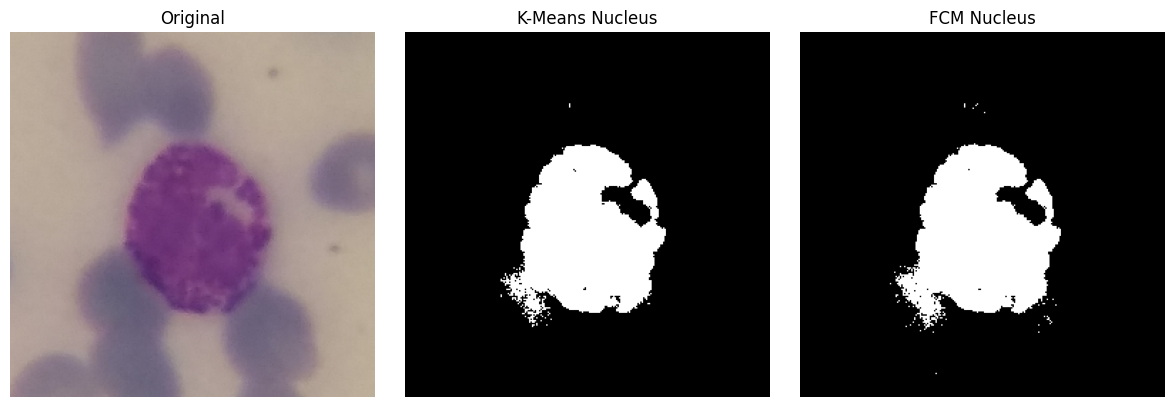

In [8]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(nucleus_mask_kmeans, cmap='gray')
plt.title("K-Means Nucleus")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(nucleus_mask_fcm, cmap='gray')
plt.title("FCM Nucleus")
plt.axis("off")

plt.tight_layout()
plt.show()


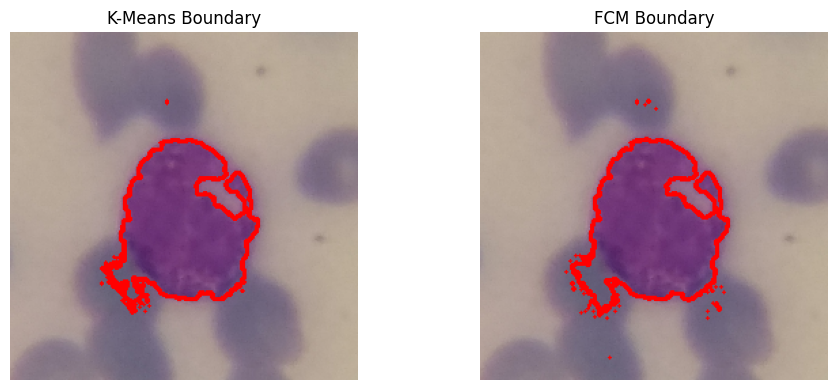

In [9]:
boundary_k = image.copy()
boundary_f = image.copy()

cv2.drawContours(boundary_k, contours_k, -1, (255,0,0), 2)
cv2.drawContours(boundary_f, contours_f, -1, (255,0,0), 2)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(boundary_k)
plt.title("K-Means Boundary")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(boundary_f)
plt.title("FCM Boundary")
plt.axis("off")

plt.tight_layout()
plt.show()


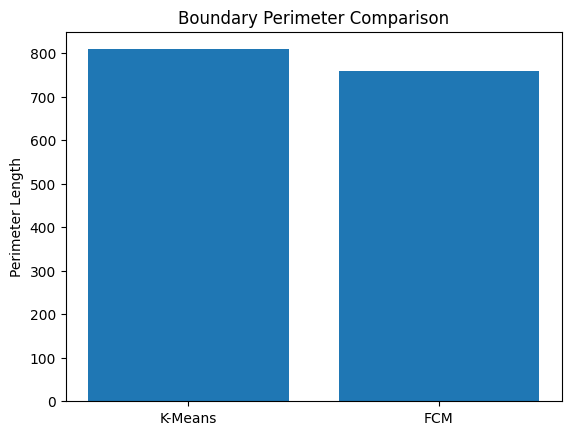

In [11]:
methods = ["K-Means", "FCM"]
boundary_values = [perimeter_k, perimeter_f]

plt.bar(methods, boundary_values)
plt.title("Boundary Perimeter Comparison")
plt.ylabel("Perimeter Length")
plt.show()
